In [1]:
import os
import open3d as o3d
import numpy as np
from plyfile import PlyData, PlyElement
from torch import nn
import torch
from errno import EEXIST
import math
from matplotlib import pyplot as plt
import json


# Util

In [2]:
class GaussianModel:

    def __init__(self, sh_degree : int):
        self.active_sh_degree = 0
        self.max_sh_degree = sh_degree  
        self._xyz = torch.empty(0)
        self._features_dc = torch.empty(0)
        self._features_rest = torch.empty(0)
        self._scaling = torch.empty(0)
        self._rotation = torch.empty(0)
        self._opacity = torch.empty(0)
        self._normal = torch.empty(0)
        self.max_radii2D = torch.empty(0)
        self.xyz_gradient_accum = torch.empty(0)
        self.denom = torch.empty(0)
        self.optimizer = None
        self.percent_dense = 0
        self.spatial_lr_scale = 0

    def save_ply(self, path):

        xyz = self._xyz.detach().cpu().numpy()
        # normals = np.zeros_like(xyz)
        normals = self._normal.detach().cpu().numpy()
        f_dc = self._features_dc.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
        f_rest = self._features_rest.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
        opacities = self._opacity.detach().cpu().numpy()
        scale = self._scaling.detach().cpu().numpy()
        rotation = self._rotation.detach().cpu().numpy()

        dtype_full = [(attribute, 'f4') for attribute in self.construct_list_of_attributes()]

        elements = np.empty(xyz.shape[0], dtype=dtype_full)
        attributes = np.concatenate((xyz, normals, f_dc, f_rest, opacities, scale, rotation), axis=1)
        elements[:] = list(map(tuple, attributes))
        el = PlyElement.describe(elements, 'vertex')
        PlyData([el]).write(path)

    def load_ply(self, path):
        plydata = PlyData.read(path)

        xyz = np.stack((np.asarray(plydata.elements[0]["x"]),
                        np.asarray(plydata.elements[0]["y"]),
                        np.asarray(plydata.elements[0]["z"])),  axis=1)
        normals = np.stack((np.asarray(plydata.elements[0]["nx"]),
                            np.asarray(plydata.elements[0]["ny"]),
                            np.asarray(plydata.elements[0]["nz"])),  axis=1)
        opacities = np.asarray(plydata.elements[0]["opacity"])[..., np.newaxis]

        features_dc = np.zeros((xyz.shape[0], 3, 1))
        features_dc[:, 0, 0] = np.asarray(plydata.elements[0]["f_dc_0"])
        features_dc[:, 1, 0] = np.asarray(plydata.elements[0]["f_dc_1"])
        features_dc[:, 2, 0] = np.asarray(plydata.elements[0]["f_dc_2"])

        extra_f_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("f_rest_")]
        extra_f_names = sorted(extra_f_names, key = lambda x: int(x.split('_')[-1]))
        assert len(extra_f_names)==3*(self.max_sh_degree + 1) ** 2 - 3
        features_extra = np.zeros((xyz.shape[0], len(extra_f_names)))
        for idx, attr_name in enumerate(extra_f_names):
            features_extra[:, idx] = np.asarray(plydata.elements[0][attr_name])
        # Reshape (P,F*SH_coeffs) to (P, F, SH_coeffs except DC)
        features_extra = features_extra.reshape((features_extra.shape[0], 3, (self.max_sh_degree + 1) ** 2 - 1))

        scales = self._extracted_from_load_ply_26(plydata, "scale_", xyz)
        rots = self._extracted_from_load_ply_26(plydata, "rot", xyz)
        self._xyz = torch.tensor(xyz, dtype=torch.float, device="cpu")
        self._normal = torch.tensor(normals, dtype=torch.float, device="cpu")
        self._features_dc = torch.tensor(features_dc, dtype=torch.float, device="cpu").transpose(1, 2).contiguous()
        self._features_rest = torch.tensor(features_extra, dtype=torch.float, device="cpu").transpose(1, 2).contiguous()
        self._opacity = torch.tensor(opacities, dtype=torch.float, device="cpu")
        self._scaling = torch.tensor(scales, dtype=torch.float, device="cpu")
        self._rotation = torch.tensor(rots, dtype=torch.float, device="cpu")

        self.active_sh_degree = self.max_sh_degree

    def _extracted_from_load_ply_26(self, plydata, arg1, xyz):
        scale_names = [
            p.name
            for p in plydata.elements[0].properties
            if p.name.startswith(arg1)
        ]
        scale_names = sorted(scale_names, key = lambda x: int(x.split('_')[-1]))
        result = np.zeros((xyz.shape[0], len(scale_names)))
        for idx, attr_name in enumerate(scale_names):
            result[:, idx] = np.asarray(plydata.elements[0][attr_name])

        return result

    def construct_list_of_attributes(self):
        l = ['x', 'y', 'z', 'nx', 'ny', 'nz']
        # All channels except the 3 DC
        l.extend(
            f'f_dc_{i}'
            for i in range(self._features_dc.shape[1] * self._features_dc.shape[2])
        )
        l.extend(
            f'f_rest_{i}'
            for i in range(
                self._features_rest.shape[1] * self._features_rest.shape[2]
            )
        )
        l.append('opacity')
        l.extend(f'scale_{i}' for i in range(self._scaling.shape[1]))
        l.extend(f'rot_{i}' for i in range(self._rotation.shape[1]))
        return l
    


# Working on a dataset "The VR-NeRF Eyeful Tower Dataset". 

- https://github.com/facebookresearch/EyefulTower?tab=readme-ov-file
- This dataset is originally used for NeRF. 

In [26]:
'''
1. Move all the images from different cameras into the same file
2. Downsample the number of dataset
2. Convert all the images to executable format for 3DGS
'''

dataset_dir = "/home/yuang/Desktop/3d_gaussian_splat/dataset/source/eyefultower/apartment/images-jpeg-2k"
input_dir = "/home/yuang/Desktop/3d_gaussian_splat/dataset/source/eyefultower/apartment/input"

In [27]:
# # for each dir in dataset_dir, move all files with extension .jpg in the dir to input_dir
# for dir in os.listdir(dataset_dir):
#     if os.path.isdir(os.path.join(dataset_dir, dir)):
#         for file in os.listdir(os.path.join(dataset_dir, dir)):
#             if file.endswith(".jpg"):
#                 os.rename(os.path.join(dataset_dir, dir, file), os.path.join(input_dir, file))
#                 print(f"move {file} to {input_dir}")

In [ ]:
# uniformly select n images from the input_dir over all the images, not randomly
n = 1750
selected_files = []
input_files = os.listdir(input_dir)
input_files.sort()
# selected_files = input_files[::math.ceil((len(input_files)/n))]
interval = len(input_files) / n
index = 0
while len(selected_files) < n and index < len(input_files):
    selected_files.append(input_files[int(index)])
    index += interval


# **copy** the selected images to a new dir
output_dir = f"/home/yuang/Desktop/3d_gaussian_splat/dataset/source/eyefultower/apartment_{n}/input"
try:
    os.makedirs(output_dir)
except OSError as e:
    if e.errno != EEXIST:
        raise
for file in selected_files:
    os.system(f"cp {os.path.join(input_dir, file)} {output_dir}")
    print(f"copy {file} to {output_dir}")


In [ ]:
# convert the images to executable format
# python convert.py -s {the parent dir of input_dir}
# os.system(f"python convert.py -s {os.path.dirname(input_dir)}")

# Data distribution of 3DGS

In [124]:
gs = GaussianModel(3)
gs.load_ply("/Users/yuangshi/Documents/PhD/3DGS/quantization/drjohnson.ply")

In [125]:
gs._xyz.shape, gs._features_dc.shape, gs._features_rest.shape, gs._opacity.shape, gs._scaling.shape, gs._rotation.shape

(torch.Size([3405153, 3]),
 torch.Size([3405153, 1, 3]),
 torch.Size([3405153, 15, 3]),
 torch.Size([3405153, 1]),
 torch.Size([3405153, 3]),
 torch.Size([3405153, 4]))

In [126]:
position = gs._xyz
features_dc = gs._features_dc
features_rest = gs._features_rest
opacity = gs._opacity
scaling = gs._scaling
rotation = gs._rotation


In [127]:
x = position[:, 0]
y = position[:, 1]
z = position[:, 2]


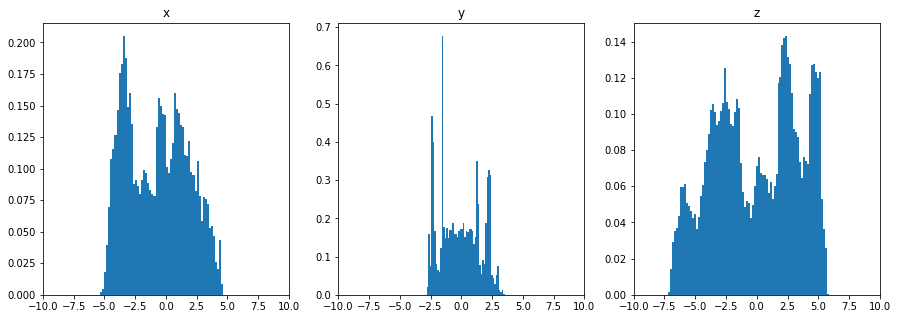

In [131]:
# get the CDF of x, y, z separately

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(x, bins=100, density=True)
axs[0].set_xlim(-10, 10)
axs[0].set_title('x')
axs[1].hist(y, bins=100, density=True)
axs[1].set_title('y')
axs[1].set_xlim(-10, 10)
axs[2].hist(z, bins=100, density=True)
axs[2].set_title('z')
axs[2].set_xlim(-10, 10)
plt.show()


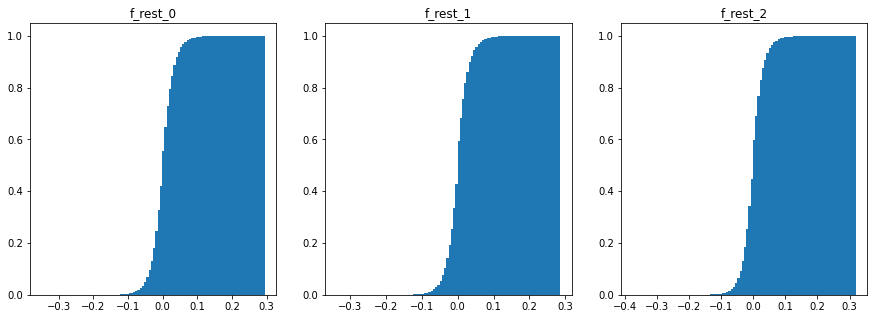

In [21]:
# get the histograms to plot the distribution of feature_rest

f_rest = features_rest.flatten(start_dim=1).contiguous()
f_rest = f_rest.detach().cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(f_rest[:, 0], bins=100, cumulative=True, density=True)
axs[0].set_title('f_rest_0')
axs[1].hist(f_rest[:, 1], bins=100, cumulative=True, density=True)
axs[1].set_title('f_rest_1')
axs[2].hist(f_rest[:, 2], bins=100, cumulative=True, density=True)
axs[2].set_title('f_rest_2')
plt.show()



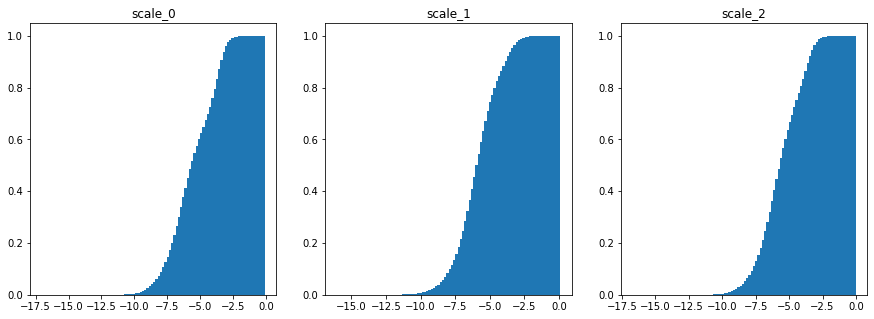

In [22]:
# get the histograms to plot the distribution of scale

scales = scaling.detach().cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(scales[:, 0], bins=100, cumulative=True, density=True)
axs[0].set_title('scale_0')
axs[1].hist(scales[:, 1], bins=100, cumulative=True, density=True)
axs[1].set_title('scale_1')
axs[2].hist(scales[:, 2], bins=100, cumulative=True, density=True)
axs[2].set_title('scale_2')
plt.show()


# Using quantization to make distorted 3DGS

- Perform quantization on bit depth to make distorted 3DGS.

In [51]:

def quantize_array(arr, bit_depth):
    # Calculate the maximum value based on the desired bit depth
    max_value = (2 ** bit_depth) - 1

    return np.round(arr * max_value) / max_value

In [55]:
# we group the features into three groups: 
    # 1. position: xyz, 
    # 2. color: normal, features_dc, features_rest, opacity
    # 3. size: scaling, rotation

path = "/home/yuang/Desktop/3d_gaussian_splat/dataset/pre-trained_model/drjohnson/point_cloud/iteration_30000/point_cloud.ply"
max_sh_degree = 3

gm = GaussianModel(max_sh_degree)
gm.load_ply(path)

# quantize the features in each group separately, and save the quantized features to a ply file
bit_depth = 4
quantized_xyz = quantize_array(gm._xyz.detach().cpu().numpy(), bit_depth)
quantized_normal = quantize_array(gm._normal.detach().cpu().numpy(), bit_depth)
quantized_features_dc = quantize_array(gm._features_dc.detach().cpu().numpy(), bit_depth)
quantized_features_rest = quantize_array(gm._features_rest.detach().cpu().numpy(), bit_depth)
quantized_opacity = quantize_array(gm._opacity.detach().cpu().numpy(), bit_depth)
quantized_scaling = quantize_array(gm._scaling.detach().cpu().numpy(), bit_depth)
quantized_rotation = quantize_array(gm._rotation.detach().cpu().numpy(), bit_depth)

# save the quantized features to a ply file
quantize_group_list = ["position", "color", "size"]
for group in quantize_group_list:
    if group == "position":
        print("quantize position")
        gm.load_ply(path)
        gm._xyz = nn.Parameter(torch.tensor(quantized_xyz, dtype=torch.float, device="cpu"))
        gm.save_ply(f"/home/yuang/Desktop/3d_gaussian_splat/dataset/pre-trained_model/drjohnson/point_cloud/iteration_30000/point_cloud_{group}_quantized.ply")
    elif group == "color":
        print("quantize color")
        gm.load_ply(path)
        gm._normal = nn.Parameter(torch.tensor(quantized_normal, dtype=torch.float, device="cpu"))
        gm._features_dc = nn.Parameter(torch.tensor(quantized_features_dc, dtype=torch.float, device="cpu"))
        gm._features_rest = nn.Parameter(torch.tensor(quantized_features_rest, dtype=torch.float, device="cpu"))
        gm._opacity = nn.Parameter(torch.tensor(quantized_opacity, dtype=torch.float, device="cpu"))
        gm.save_ply(f"/home/yuang/Desktop/3d_gaussian_splat/dataset/pre-trained_model/drjohnson/point_cloud/iteration_30000/point_cloud_{group}_quantized.ply")
    elif group == "size":
        print("quantize size")
        gm.load_ply(path)
        gm._scaling = nn.Parameter(torch.tensor(quantized_scaling, dtype=torch.float, device="cpu"))
        gm._rotation = nn.Parameter(torch.tensor(quantized_rotation, dtype=torch.float, device="cpu"))
        gm.save_ply(f"/home/yuang/Desktop/3d_gaussian_splat/dataset/pre-trained_model/drjohnson/point_cloud/iteration_30000/point_cloud_{group}_quantized.ply")

# Relation between dataset size and quality

In [77]:
root = "/Volumes/Research/3dgs-dataset/apartment"

dataset_size_list = [200, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250]
size_quality_dict = {}

for size in dataset_size_list:
    size_quality_dict[size] = {}
    input_dir = f"{root}/subset_{size}/per_view.json"
    results = json.load(open(input_dir))
    # read the SSIM, PSNR, LPIPS from the results
    for key in results.keys():
        for metric in results[key].keys():
            size_quality_dict[size][metric] = []
            for png in results[key][metric].keys():
                eva_value = results[key][metric][png]
                size_quality_dict[size][metric].append(eva_value)
size_quality_dict

{200: {'SSIM': [0.8480948805809021,
   0.8756288290023804,
   0.9048101305961609,
   0.9316938519477844,
   0.9201254844665527,
   0.9433057904243469,
   0.9100098013877869,
   0.917456328868866,
   0.8461963534355164,
   0.8990298509597778,
   0.8999348282814026,
   0.9178481101989746,
   0.8812767267227173,
   0.8589499592781067,
   0.9191498756408691,
   0.8791859745979309,
   0.943172812461853,
   0.9330657124519348,
   0.9004277586936951,
   0.9381030797958374,
   0.9378057718276978,
   0.8608532547950745,
   0.8772221803665161,
   0.8811655640602112,
   0.9190126061439514,
   0.8875206112861633,
   0.9413645267486572,
   0.9012928605079651,
   0.9207757115364075,
   0.9438386559486389,
   0.9136399626731873,
   0.8581712245941162,
   0.9123445749282837,
   0.8754790425300598,
   0.9331868290901184,
   0.9200870394706726,
   0.8833127021789551,
   0.921973466873169,
   0.8859053254127502,
   0.9193122386932373,
   0.9098911881446838,
   0.8378034830093384,
   0.8947083353996277,
 

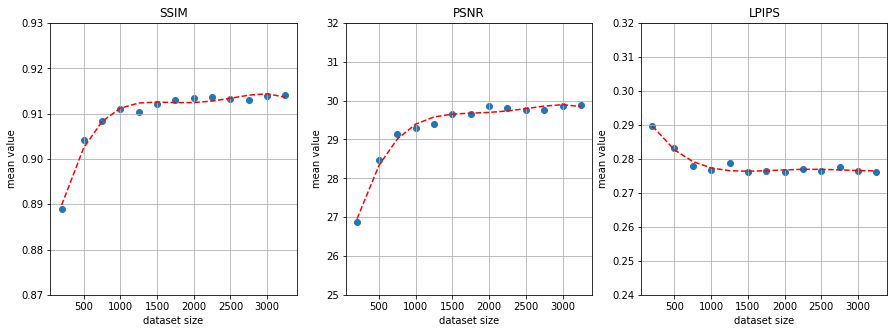

In [78]:
# plot the mean SSIM, PSNR, LPIPS against the dataset size
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for metric, ax in zip(size_quality_dict[dataset_size_list[0]].keys(), axs):
    ax.scatter(dataset_size_list, [np.mean(size_quality_dict[size][metric]) for size in dataset_size_list], marker='o')
    ax.set_title(metric)
    ax.set_xlabel("dataset size")
    ax.set_ylabel("mean value")
    ax.grid()
    if metric == "SSIM":
        ax.set_ylim(0.87, 0.93)
    elif metric == "PSNR":
        ax.set_ylim(25, 32)
    elif metric == "LPIPS":
        ax.set_ylim(0.24, 0.32)
    
    
    # plot a fitted line based on the points, using polyfit with degree 2
    x = np.array(dataset_size_list)
    y = np.array([np.mean(size_quality_dict[size][metric]) for size in dataset_size_list])
    z = np.polyfit(x, y, 4)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--")

    
plt.show()

In [88]:
np.mean(size_quality_dict[1000]["SSIM"]), np.mean(size_quality_dict[1000]["PSNR"]), np.mean(size_quality_dict[1000]["LPIPS"])
# np.mean(size_quality_dict[200]["SSIM"]), np.mean(size_quality_dict[200]["PSNR"]), np.mean(size_quality_dict[200]["LPIPS"])

(0.9111075070312897, 29.29347253207788, 0.27669457005187387)

In [180]:
np.std(size_quality_dict[1000]["SSIM"]), np.std(size_quality_dict[1000]["PSNR"]), np.std(size_quality_dict[1000]["LPIPS"])

(0.04146034839269542, 4.100410089077829, 0.037879408871627905)

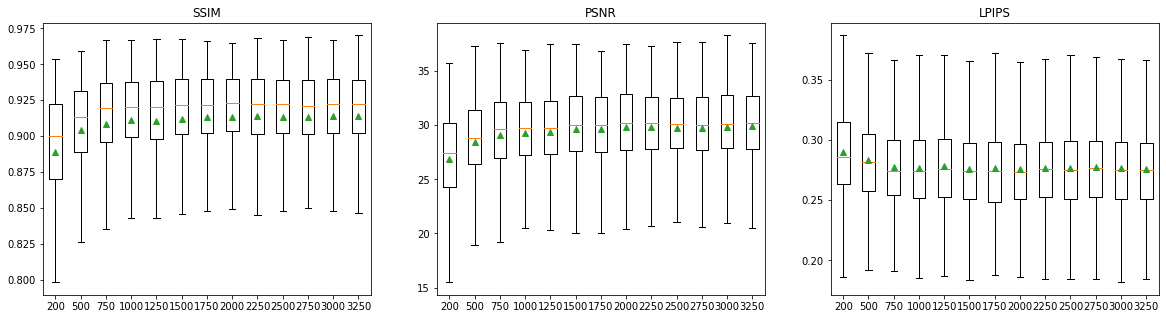

In [83]:
# plot the SSIM, PSNR, LPIPS against the dataset size
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

dataset_size_list = list(size_quality_dict.keys())
ssim_list = [np.array(value['SSIM']).mean() for value in size_quality_dict.values()]
psnr_list = [np.array(value['PSNR']).mean() for value in size_quality_dict.values()]
lpips_list = [np.array(value['LPIPS']).mean() for value in size_quality_dict.values()]

# axs[0].plot(dataset_size_list, ssim_list, marker='o')
axs[0].boxplot([np.array(value['SSIM']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[0].set_title('SSIM')
# axs[0].set_ylim(0.87, 0.93)

# axs[1].plot(dataset_size_list, psnr_list, marker='o')
axs[1].boxplot([np.array(value['PSNR']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[1].set_title('PSNR')
# axs[1].set_ylim(25, 32)

# axs[2].plot(dataset_size_list, lpips_list, marker='o')
axs[2].boxplot([np.array(value['LPIPS']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[2].set_title('LPIPS')
# axs[2].set_xlim(0, 1450)
# axs[2].set_ylim(0.24, 0.32)


plt.show()

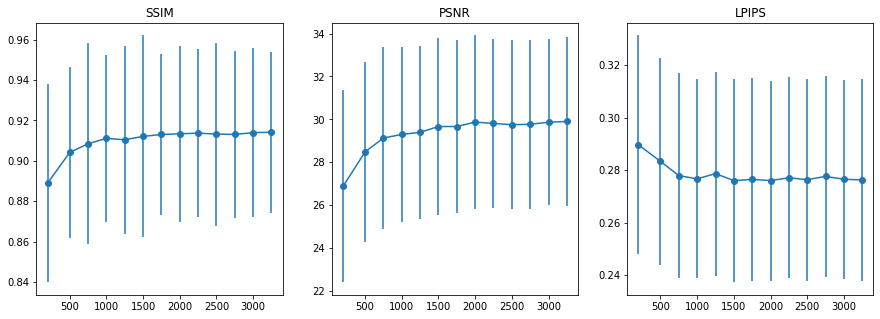

In [41]:
# plot the SSIM, PSNR, LPIPS against the dataset size
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

dataset_size_list = size_quality_dict.keys()
ssim_list = [np.array(value['SSIM']).mean() for value in size_quality_dict.values()]
psnr_list = [np.array(value['PSNR']).mean() for value in size_quality_dict.values()]
lpips_list = [np.array(value['LPIPS']).mean() for value in size_quality_dict.values()]

axs[0].errorbar(dataset_size_list, ssim_list, yerr=[np.array(value['SSIM']).std() for value in size_quality_dict.values()], fmt='o-')
axs[0].set_title('SSIM')
# axs[0].set_ylim(0.85, 0.93)

axs[1].errorbar(dataset_size_list, psnr_list, yerr=[np.array(value['PSNR']).std() for value in size_quality_dict.values()], fmt='o-')
axs[1].set_title('PSNR')
# axs[1].set_ylim(27, 30.5)

axs[2].errorbar(dataset_size_list, lpips_list, yerr=[np.array(value['LPIPS']).std() for value in size_quality_dict.values()], fmt='o-')
axs[2].set_title('LPIPS')
# axs[2].set_ylim(0.25, 0.35)


plt.show()

In [171]:
[np.array(value['SSIM']).std() for value in size_quality_dict.values()], [np.array(value['PSNR']).std() for value in size_quality_dict.values()], [np.array(value['LPIPS']).std() for value in size_quality_dict.values()]

([0.04912162693187911,
  0.0424020215047463,
  0.04971047828101969,
  0.04146034839269542,
  0.0465695105006564,
  0.04999105195511727,
  0.04004421647810057,
  0.04353512902408483,
  0.041487400467078904,
  0.045288556550926555,
  0.041344808211134426,
  0.04185433600544574,
  0.039739299289877746],
 [4.48197617520393,
  4.2010513565536245,
  4.236697509046365,
  4.100410089077829,
  4.038828155941046,
  4.1121964717334105,
  4.01558316268922,
  4.04587806345475,
  3.9412298789506166,
  3.943387961643294,
  3.9480693538542657,
  3.8619003111878607,
  3.954311570610341],
 [0.04164541253413965,
  0.03953173323746875,
  0.03912637078095191,
  0.037879408871627905,
  0.03879761392121594,
  0.03874279366321463,
  0.03846837806408938,
  0.038083528566745496,
  0.038188815562611965,
  0.03844311526151596,
  0.03836683204433124,
  0.037848072136360815,
  0.03843089020869686])

# 3DGS Denoise

## Pre-processing

### Position-guided-filter for initilized point cloud denoising
- https://github.com/aipiano/guided-filter-point-cloud-denoise
- And also perform outlier removal

In [157]:
def guided_filter(pcd, radius, epsilon, neigbor_num_threshold=3):
    kdtree = o3d.geometry.KDTreeFlann(pcd)
    points_copy = np.array(pcd.points)
    points = np.asarray(pcd.points)
    num_points = len(pcd.points)

    for i in range(num_points):
        k, idx, _ = kdtree.search_radius_vector_3d(pcd.points[i], radius)
        if k < neigbor_num_threshold:
            continue

        neighbors = points[idx, :]
        mean = np.mean(neighbors, 0)
        cov = np.cov(neighbors.T)
        e = np.linalg.inv(cov + epsilon * np.eye(3))

        A = cov @ e
        b = mean - A @ mean

        points_copy[i] = A @ points[i] + b

    pcd.points = o3d.utility.Vector3dVector(points_copy)


def noise_removal(pcd, radius, neigbor_num_threshold=3):
    kdtree = o3d.geometry.KDTreeFlann(pcd)
    points_copy = np.array(pcd.points)
    points = np.asarray(pcd.points)
    num_points = len(pcd.points)
    mask_point_indice = []

    for i in range(num_points):
        k, idx, _ = kdtree.search_radius_vector_3d(pcd.points[i], radius)
        # if the number of neighbors is less than 3, mask out the point
        if k < neigbor_num_threshold:
            mask_point_indice.append(i)
    
    # mask out the points that are not in the neighborhood, given the index of the points mask_point_indice
    points_copy = np.delete(points_copy, mask_point_indice, axis=0)

    pcd.points = o3d.utility.Vector3dVector(points_copy)
    pcd.colors = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.colors), mask_point_indice, axis=0))
    pcd.normals = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.normals), mask_point_indice, axis=0))

In [146]:
pcd_path = "/Volumes/Research/3dgs-dataset/points3D.ply"
pcd = o3d.io.read_point_cloud(pcd_path)

In [93]:
pcd_path = "/Volumes/Research/3dgs-dataset/points3D.ply"
pcd = o3d.io.read_point_cloud(pcd_path)
guided_filter(pcd, 0.05, 0.01)
# guided_filter(pcd, 0.05, 0.01)
o3d.io.write_point_cloud("/Volumes/Research/3dgs-dataset/points3D_filtered.ply", pcd)

True

In [158]:
pcd_path = "/Volumes/Research/3dgs-dataset/points3D.ply"
pcd = o3d.io.read_point_cloud(pcd_path)

noise_removal(pcd=pcd, radius=0.05, neigbor_num_threshold=2)
o3d.io.write_point_cloud("/Volumes/Research/3dgs-dataset/points3D_removed.ply", pcd)

guided_filter(pcd=pcd, radius=0.05, epsilon=0.01, neigbor_num_threshold=3)
o3d.io.write_point_cloud("/Volumes/Research/3dgs-dataset/points3D_removed_filtered.ply", pcd)

True

#### Evaluation

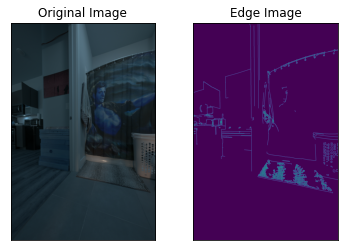

In [196]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
 
img = cv.imread('/Volumes/Research/3dgs-dataset/apartment/subset_1000/test/ours_30000/gt/00100.png',)
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img, 50, 150) / 255


plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
 
plt.show()

In [202]:
size_quality_dict_100 = {}
input_dir = f"{root}/subset_filter_1000/per_view.json"
results = json.load(open(input_dir))
# read the SSIM, PSNR, LPIPS from the results
for key in results.keys():
    for metric in results[key].keys():
        size_quality_dict_100[metric] = []
        for png in results[key][metric].keys():
            eva_value = results[key][metric][png]
            size_quality_dict_100[metric].append(eva_value)

In [203]:
# std of SSIM, PSNR, LPIPS
np.std(size_quality_dict_100['SSIM']), np.std(size_quality_dict_100['PSNR']), np.std(size_quality_dict_100['LPIPS'])

(0.04310731675211222, 4.030165020009551, 0.0377082296258062)

0.27692030644985705 0.27669457005187387


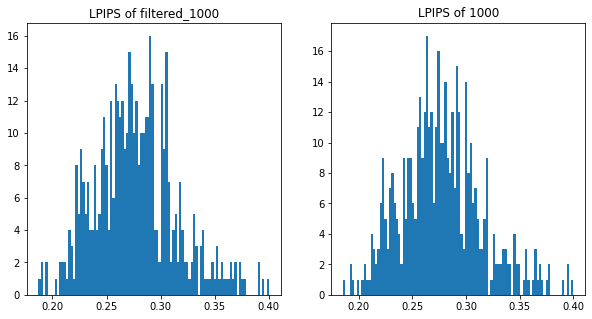

In [223]:
# distribution of size_quality_dict_100['SSIM'] and size_quality_dict[1000]['SSIM']
metric = "LPIPS"
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(size_quality_dict_100[metric], bins=100)
axs[0].set_title(f'{metric} of filtered_1000')
# axs[0].set_xlim(0.6, 1)
# axs[0].set_ylim(0, 40)

axs[1].hist(size_quality_dict[1000][metric], bins=100)
axs[1].set_title(f'{metric} of 1000')
# axs[1].set_xlim(0.6, 1)
# axs[1].set_ylim(0, 40)

print(np.mean(size_quality_dict_100[metric]), np.mean(size_quality_dict[1000][metric]))

## Post-processing

### Position-guided-filter for 3DGS denoising

- https://github.com/aipiano/guided-filter-point-cloud-denoise
- Performance is very bad. Because only the position changed, the color and size is not changed. The position does look better.
  - Perhaps we can make it during the training process.

In [80]:
def guided_filter(pcd, radius, epsilon):
    kdtree = o3d.geometry.KDTreeFlann(pcd)
    points_copy = np.array(pcd.points)
    points = np.asarray(pcd.points)
    num_points = len(pcd.points)

    for i in range(num_points):
        k, idx, _ = kdtree.search_radius_vector_3d(pcd.points[i], radius)
        if k < 3:
            continue

        neighbors = points[idx, :]
        mean = np.mean(neighbors, 0)
        cov = np.cov(neighbors.T)
        e = np.linalg.inv(cov + epsilon * np.eye(3))

        A = cov @ e
        b = mean - A @ mean

        points_copy[i] = A @ points[i] + b

    pcd.points = o3d.utility.Vector3dVector(points_copy)

def noise_removal(gs, radius, neigbor_num_threshold=3, dispersion_threshold=20):
    position = gs._xyz
    # select the points whose x, y, and z are in the 25% to 75% percentile
    x = position[:, 0]
    y = position[:, 1]
    z = position[:, 2]
    x_25, x_75 = np.percentile(x, 25), np.percentile(x, 75)
    y_25, y_75 = np.percentile(y, 25), np.percentile(y, 75)
    z_25, z_75 = np.percentile(z, 25), np.percentile(z, 75)

    opacity = gs._opacity.detach().cpu().numpy()
    opacity_25 = np.percentile(opacity, 60)
    
    scales = gs._scaling.detach().cpu().numpy()
    dispersion = np.array([scale @ scale.T for scale in scales])

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(position)

    kdtree = o3d.geometry.KDTreeFlann(pcd)
    points_copy = np.array(pcd.points)
    points = np.asarray(pcd.points)
    num_points = len(pcd.points)
    mask_point_indice = []

    for i in range(num_points):
        k, idx, _ = kdtree.search_radius_vector_3d(pcd.points[i], radius)
        # if the number of neighbors is less than neigbor_num_threshold, mask out the point
        # select the points whose x, y, and z are in the 25% to 75% percentile
        if k < neigbor_num_threshold and opacity[i] < opacity_25: # and dispersion[i] < dispersion_threshold and x_25 < x[i] < x_75 and y_25 < y[i] < y_75 and z_25 < z[i] < z_75 
            mask_point_indice.append(i)

    # # mask out the points that are not in the neighborhood, given the index of the points mask_point_indice
    # points_copy = np.delete(points_copy, mask_point_indice, axis=0)

    # pcd.points = o3d.utility.Vector3dVector(points_copy)
    # pcd.colors = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.colors), mask_point_indice, axis=0))
    # pcd.normals = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.normals), mask_point_indice, axis=0))
    return mask_point_indice

In [81]:
gs = GaussianModel(3)
gs.load_ply("/Users/yuangshi/Documents/PhD/3DGS/denoising/apartment_1000.ply")

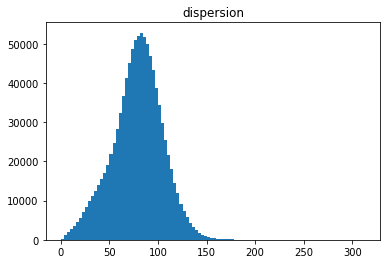

In [82]:
# for each scale in the scales, get a list of scale times the transpose of the scale
scales = gs._scaling.detach().cpu().numpy()
dispersion = np.array([scale @ scale.T for scale in scales])

# get the distribution of the dispersion (a list of values)
fig = plt.hist(dispersion, bins=100)
plt.title('dispersion')
plt.show()

In [83]:
opacity = gs._opacity
opacity = [item[0] for item in opacity]

np.percentile(gs._opacity, 0), np.percentile(gs._opacity, 25), np.percentile(gs._opacity, 50), np.percentile(gs._opacity, 60), np.percentile(gs._opacity, 75), np.percentile(gs._opacity, 100)

(-7.081196308135986,
 -3.5980820655822754,
 -1.0485879778862,
 0.356890428066253,
 3.4080735445022583,
 18.1163387298584)

In [84]:
mask_point_indice = noise_removal(gs, radius=0.1, neigbor_num_threshold=25, dispersion_threshold=np.quantile(dispersion, 0.0001))

In [85]:
gs._xyz = torch.tensor(np.delete(np.array(gs._xyz), mask_point_indice, axis=0), dtype=torch.float, device="cpu")
gs._normals = torch.tensor(np.delete(np.array(gs._normal), mask_point_indice, axis=0), dtype=torch.float, device="cpu")
gs._features_dc = torch.tensor(np.delete(np.array(gs._features_dc), mask_point_indice, axis=0), dtype=torch.float, device="cpu")
gs._features_rest = torch.tensor(np.delete(np.array(gs._features_rest), mask_point_indice, axis=0), dtype=torch.float, device="cpu")
gs._opacity = torch.tensor(np.delete(np.array(gs._opacity), mask_point_indice, axis=0), dtype=torch.float, device="cpu")
gs._scaling = torch.tensor(np.delete(np.array(gs._scaling), mask_point_indice, axis=0), dtype=torch.float, device="cpu")
gs._rotation = torch.tensor(np.delete(np.array(gs._rotation), mask_point_indice, axis=0), dtype=torch.float, device="cpu")

assert len(gs._xyz) == len(gs._features_dc) == len(gs._features_rest) == len(gs._opacity) == len(gs._scaling) == len(gs._rotation) == len(gs._normals)

In [86]:
xyz = gs._xyz.detach().cpu().numpy()
normals = np.zeros_like(xyz)
f_dc = gs._features_dc.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
f_rest = gs._features_rest.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
opacities = gs._opacity.detach().cpu().numpy()
scale = gs._scaling.detach().cpu().numpy()
rotation = gs._rotation.detach().cpu().numpy()

print(len(xyz), len(normals), len(f_dc), len(f_rest), len(opacities), len(scale), len(rotation))

932957 932957 932957 932957 932957 932957 932957


In [87]:
path = "/Users/yuangshi/Documents/PhD/3DGS/denoising/apartment_1000_removed.ply"

dtype_full = [(attribute, 'f4') for attribute in gs.construct_list_of_attributes()]

elements = np.empty(xyz.shape[0], dtype=dtype_full)
attributes = np.concatenate((xyz, normals, f_dc, f_rest, opacities, scale, rotation), axis=1)
elements[:] = list(map(tuple, attributes))
el = PlyElement.describe(elements, 'vertex')
PlyData([el]).write(path)